In [85]:
import xgboost as xgb
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [86]:
stock = yf.Ticker("TSLA")
df = stock.history(period="2y", interval='1h').drop(columns=["Dividends", "Stock Splits"])
df.head()

,Open,High,Low,Close,Volume
2020-06-29 14:30:00-04:00,198.183990,199.397995,197.197998,199.392853,0
2020-06-29 15:30:00-04:00,199.328003,202.000000,199.279999,201.977997,1875183
2020-06-30 09:30:00-04:00,201.300003,209.756012,200.746002,209.117111,4275784
2020-06-30 10:30:00-04:00,209.095993,212.769989,208.779999,212.519989,2456949
2020-06-30 11:30:00-04:00,212.537994,217.537994,212.522003,216.537994,3733572


Bring index column(date) in column and set the index sequential numbers

In [87]:
df2 = df.copy()
df2.reset_index(inplace=True)
df2.head()

,index,Open,High,Low,Close,Volume
0,2020-06-29 14:30:00-04:00,198.183990,199.397995,197.197998,199.392853,0
1,2020-06-29 15:30:00-04:00,199.328003,202.000000,199.279999,201.977997,1875183
2,2020-06-30 09:30:00-04:00,201.300003,209.756012,200.746002,209.117111,4275784
3,2020-06-30 10:30:00-04:00,209.095993,212.769989,208.779999,212.519989,2456949
4,2020-06-30 11:30:00-04:00,212.537994,217.537994,212.522003,216.537994,3733572


In [88]:
df2.shape

(3521, 6)

### show the stock price history graph

<AxesSubplot:>

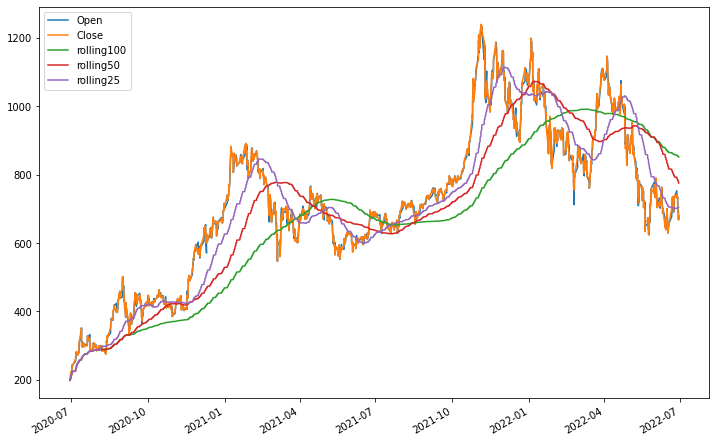

In [89]:
df3 = df.copy()
df3['rolling100'] = df3[['Close']].rolling(window=7*100, min_periods=1).mean()
df3['rolling50'] = df3[['Close']].rolling(window=7*50, min_periods=1).mean()
df3['rolling25'] = df3[['Close']].rolling(window=7*25, min_periods=1).mean()
df3.drop(columns=["High", "Low", "Volume"], inplace=True)
df3.plot(figsize=(12,8))

In [90]:
df3.reset_index(inplace=True)
df3["Date"] = df3.index
df3.drop(columns=["index", "Open"], inplace=True)
df3.head()

,Close,rolling100,rolling50,rolling25,Date
0,199.392853,199.392853,199.392853,199.392853,0
1,201.977997,200.685425,200.685425,200.685425,1
2,209.117111,203.495987,203.495987,203.495987,2
3,212.519989,205.751987,205.751987,205.751987,3
4,216.537994,207.909189,207.909189,207.909189,4


In [91]:
# get the last 1 week of data (7h/day and 5 days/week)
LAST_DAYS = 7 * 5

# train data
train = df3.iloc[:-1*LAST_DAYS]
X_train = train.drop(columns=['Close']) # explanatory variable
y_train = train['Close']              # target variable

# test data
test = df3.iloc[-1*LAST_DAYS:]  #テストデータ
X_test = test.drop(columns=['Close']) # explanatory variable
y_test = test['Close']              # target variable
train.head()

,Close,rolling100,rolling50,rolling25,Date
0,199.392853,199.392853,199.392853,199.392853,0
1,201.977997,200.685425,200.685425,200.685425,1
2,209.117111,203.495987,203.495987,203.495987,2
3,212.519989,205.751987,205.751987,205.751987,3
4,216.537994,207.909189,207.909189,207.909189,4


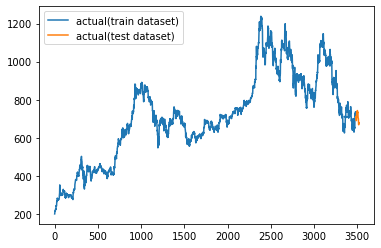

In [92]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
plt.legend()

In [93]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)])

[0]	validation_0-rmse:526.35832	validation_1-rmse:507.74119
[1]	validation_0-rmse:370.46210	validation_1-rmse:363.55301
[2]	validation_0-rmse:261.19199	validation_1-rmse:256.58506
[3]	validation_0-rmse:184.69224	validation_1-rmse:192.81098
[4]	validation_0-rmse:130.94497	validation_1-rmse:140.11775
[5]	validation_0-rmse:93.80210	validation_1-rmse:100.07477
[6]	validation_0-rmse:67.68865	validation_1-rmse:74.86166
[7]	validation_0-rmse:49.53436	validation_1-rmse:55.22693
[8]	validation_0-rmse:37.16112	validation_1-rmse:46.26145
[9]	validation_0-rmse:28.71529	validation_1-rmse:35.32288
[10]	validation_0-rmse:22.79313	validation_1-rmse:31.25455
[11]	validation_0-rmse:18.97763	validation_1-rmse:28.77641
[12]	validation_0-rmse:16.65198	validation_1-rmse:27.11919
[13]	validation_0-rmse:15.16117	validation_1-rmse:25.95144
[14]	validation_0-rmse:14.17231	validation_1-rmse:24.82156
[15]	validation_0-rmse:13.44555	validation_1-rmse:24.66188
[16]	validation_0-rmse:12.74187	validation_1-rmse:24.43

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [94]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(X_train.columns,
                                 regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
2,rolling25,0.635985
0,rolling100,0.191404
3,Date,0.146961
1,rolling50,0.025651


<AxesSubplot:xlabel='Features'>

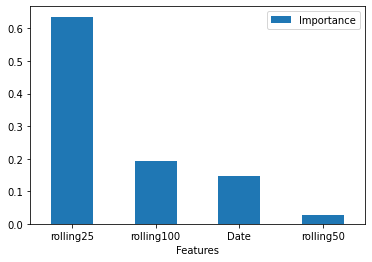

In [95]:
df_importance.plot.bar(x='Features',y='Importance', rot=0)

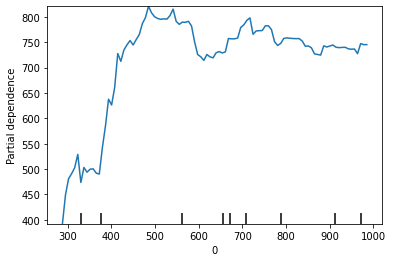

In [96]:
PartialDependenceDisplay.from_estimator(regressor, 
                                        X_train.values, 
                                        features=[0])

In [97]:
train_pred = regressor.predict(X_train.values)
test_pred = regressor.predict(X_test.values)
# 精度指標（テストデータ）
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(y_test, test_pred))

RMSE:
23.758881562560934
MAE:
20.885560825892856
MAPE:
0.02948885644530239


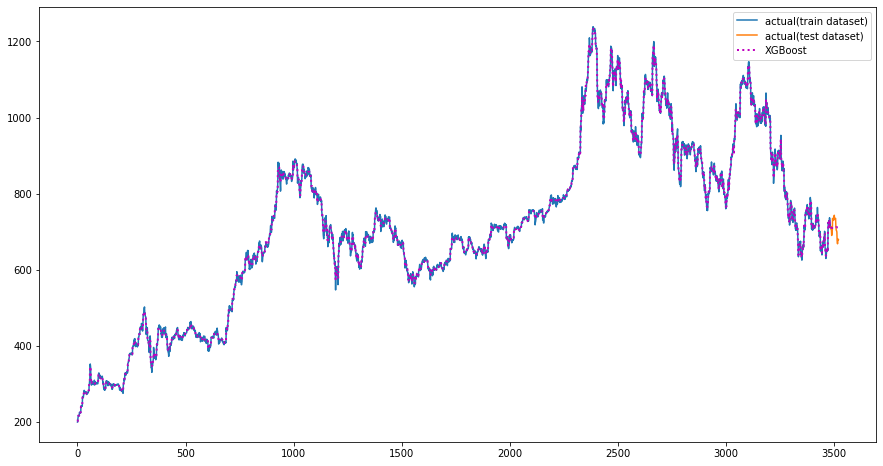

In [98]:
# グラフ化
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m") 
plt.legend()